# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from PIL import Image #
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


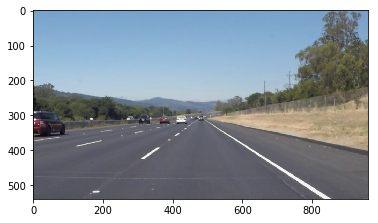

In [4]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image_gray = Image.open('test_images/solidWhiteRight.jpg').convert("L") 
image_gray = np.asarray(image_gray)


#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

#plt.subplot(122),plt.imshow(image_gray, cmap='gray')
plt.show()
#plt.imshow(image,cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [2]:
low_y=540
high_y=320

left_bound = 480
right_bound = 540
left_prev=0
right_prev=0
left_prev_bottom=0
right_prev_bottom=0

#LPF parameter
alpha=0.3

#Function for averange of a list calculation (output - int)
def mean(L):
    if math.isnan(sum(L)) or len(L)==0:
        return 0
    else:
        return int(sum(L) / float(len(L)))
    
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#Process found lines in order to draw correct lane lines only
def draw_lanes(img, lines, color=[0, 0, 255], thickness=10): #Blank(공백) 에 lines(x,y좌표들)
    global left_prev
    global right_prev
    global left_prev_bottom
    global right_prev_bottom
    #Line is y=k*x+b
    left_line=[]
    left_k=[] #기울기
    right_line=[]
    right_k=[] #기울기
    for line in lines:
        for x1,y1,x2,y2 in line:
            k=((y2-y1)/(x2-x1))
            #Filter near horizontal lines
            if abs(k)<0.5:
                continue
            if k>0:
                right_line.append(line) #오른쪽 라인 x,y좌표 리스트
                right_k.append(k) #오른쪽 라인 기울기 리스트
            else:
                left_line.append(line) #왼쪽 라인 x,y좌표 리스트
                left_k.append(k) #왼쪽 라인 기울기 리스트
    
        points=[]
        low_x=[]
        high_x=[]  
        for i,k in enumerate(left_k): #왼쪽 라인
            for x1,y1,x2,y2 in left_line[i]:
                b=y1-k*x1
                low_x.append((low_y-b)/k) #low_x가 뭘 의미???
                high_x.append((high_y-b)/k) #High_x가 뭘 의미???
        m_low_x=mean(low_x)
        m_high_x=mean(high_x)
        
        #If we are lost, use prev known
        if m_low_x == 0:
            m_low_x=left_prev_bottom
        if m_high_x == 0:
            m_high_x=left_prev
        points.append(m_low_x)
        points.append(m_high_x)
        
       #print(m_low_x), print(m_high_x)
        
        low_x=[]
        high_x=[]
        for i,k in enumerate(right_k): #오른쪽 라인
            for x1,y1,x2,y2 in right_line[i]:
                b=y1-k*x1
                low_x.append((low_y-b)/k) #low_x가 뭘 의미???
                high_x.append((high_y-b)/k) #High_x가 뭘 의미???
        m_low_x=mean(low_x)
        m_high_x=mean(high_x)

        if m_low_x == 0:
            m_low_x=right_prev_bottom
        if m_high_x == 0:
            m_high_x=right_prev
        points.append(m_low_x)
        points.append(m_high_x)
    
        #print(m_low_x), print(m_high_x)
        #print(points)
        
    #LPF for the top x position of lanes
    if left_prev==0:
        left_prev_bottom=points[0] #왼쪽 라인 m_low_x
        left_prev=points[1] #왼쪽 라인 m_High_x
        right_prev_bottom=points[2] #오른쪽 라인 m_low_x
        right_prev=points[3] #오른쪽 라인 m_High_x
    else:
        points[0]=int((1-alpha)*left_prev_bottom+alpha*points[0])
        points[1]=int((1-alpha)*left_prev+alpha*points[1])
        points[2]=int((1-alpha)*right_prev_bottom+alpha*points[2])
        points[3]=int((1-alpha)*right_prev+alpha*points[3])
        left_prev_bottom=points[0]
        left_prev=points[1]
        right_prev_bottom=points[2]
        right_prev=points[3]
        
    cv2.line(img, (points[0], low_y), (points[1], high_y), color, thickness)
    cv2.line(img, (points[2], low_y), (points[3], high_y), color, thickness)
    #Set new roi vertices
    global left_bound
    global right_bound
    left_bound=points[1]-30
    right_bound=points[3]+30
    
kernel_size = 5

#reset parameters of adaptive and video-specific features before every test on video 
def reset_params_720p():
    global left_prev
    global right_prev
    global left_prev_bottom
    global right_prev_bottom
    global left_bound
    global right_bound
    global red_threshold
    global green_threshold
    global blue_threshold
    global kernel_size
    global low_threshold
    global high_threshold
    global HoughLine_params
    global left_bound
    global right_bound
    left_prev=0
    right_prev=0
    left_prev_bottom=0
    right_prev_bottom=0
    left_bound=0
    right_bound=0

    #r>215 & g>215 & b>215 보다 높으면 White로 인식 
    red_threshold = 215
    green_threshold = 215
    blue_threshold = 215
    
    kernel_size = 3
    low_threshold = 50
    high_threshold = 150
    
    HoughLine_params = [2, 1, 15, 10, 20]
    
    #Initial guess on x-coordinates of top edges of roi
    left_bound = 540
    right_bound = 740
    
def reset_params_540p():
    global left_prev
    global right_prev
    global left_prev_bottom
    global right_prev_bottom
    global left_bound
    global right_bound
    global red_threshold
    global green_threshold
    global blue_threshold
    global kernel_size
    global low_threshold
    global high_threshold
    global HoughLine_params
    global left_bound
    global right_bound
    left_prev=0
    right_prev=0
    left_prev_bottom=0
    right_prev_bottom=0
    
    #left_bound=0
    #right_bound=0
    
    #r>210 & g>200 & b>190보다 높으면 White로 인식 
    #r>80 & g>80 & b<60 조건에 들면 노란색으로 인식 
    
    HoughLine_params= [1, 1, 25, 10, 20]
 
    red_threshold = 210
    green_threshold = 200
    blue_threshold = 190
    
    kernel_size = 1
    low_threshold = 10
    high_threshold = 30
    
    #Initial guess on x-coordinates of top edges of roi
    left_bound = 460
    right_bound = 520
    
    

def image_process(img):
    imshape = img.shape
    #If we process the first frame of a video, we need to set initial guess of the roi position
    global low_y
    global high_y
    
    #For the challenge video we have to crop frames
    if imshape[0]>700: #세로 길이가 720일 경우
        low_y=int(imshape[0]*0.94)
        high_y=int(imshape[0]/2*1.25)
    else:              #세로 길이가 540일 경우
        high_y=int(imshape[0]/2*1.18)
        low_y=int(imshape[0])
    
    vert=np.array([[(int(imshape[1]*0.05),low_y), (left_bound,high_y),(right_bound,high_y), (int(imshape[1]*0.95),low_y)]], dtype=np.int32)
    color_select = np.copy(img)
    rgb_threshold = [red_threshold, green_threshold, blue_threshold]
    # Do a bitwise or with the "|" character to identify pixels by the thresholds
    #Add white pixels
    thresholds = (img[:,:,0] > rgb_threshold[0])|(img[:,:,1] > rgb_threshold[1])|(img[:,:,2] > rgb_threshold[2])
    #Add yellow pixels, essential for the challenge task
    thresholds = thresholds|((img[:,:,0] > 80)&(img[:,:,1] > 80)&(img[:,:,2] < 60))
    color_select[thresholds==0] = [0,0,0]
    
    gray = cv2.cvtColor(color_select,cv2.COLOR_BGR2GRAY)
    #cv2.imwrite('annotated_images/1.jpg',gray)
    gray = cv2.equalizeHist(gray) #<------------------------------
    #cv2.imwrite('annotated_images/2.jpg',gray)
    gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    #cv2.imwrite('annotated_images/3.jpg',gray)
    
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    #cv2.imwrite('annotated_images/4.jpg',edges)
    
    roi=region_of_interest(edges, vert) #<-------------------------------
    #cv2.imwrite('annotated_images/5.jpg',roi)
    
    rho = HoughLine_params[0] # distance resolution in pixels of the Hough grid
    theta = HoughLine_params[1]*np.pi/180 # angular resolution in radians of the Hough grid
    threshold = HoughLine_params[2]    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = HoughLine_params[3] #minimum number of pixels making up a line
    max_line_gap = HoughLine_params[4]    # maximum gap in pixels between connectable line segments
   
    lines = cv2.HoughLinesP(roi, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    #print(lines)
    line_image = np.copy(img)*0 # creating a blank to draw lines on
    
    #Uncomment one of the following lines in order to output detected lines or lanes
    draw_lanes(line_image, lines)#Blank(공백) 에 lines(x,y좌표들)을 그린것.
    cv2.imwrite('annotated_images/6.jpg',line_image)
    result = cv2.addWeighted(img, 0.8, line_image, 1, 0)#<--------------------------------
    return result



In [27]:
#reset_params_540p()
#img = cv2.imread('test_images/whiteCarLaneSwitch.jpg')
#cv2.imwrite('annotated_images/7.jpg',img)
#line_image = np.copy(img)*0
#plt.imshow(line_image)
#plt.show()

#image_process(img)
#draw_lanes(line_image, lines) #Blank(공백) 에 lines(x,y좌표들)을 그린것.
#cv2.imwrite('annotated_images/8.jpg',image_process(img))
#plt.imshow(line_image)
#plt.show()

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [28]:
import os
os.listdir("test_images/")

['solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

(540, 960, 3)
(36, 1, 4)


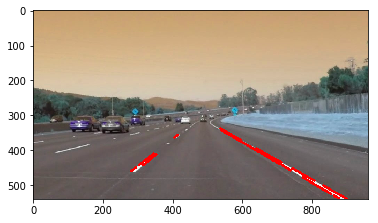

In [4]:
img = cv2.imread('test_images/solidWhiteCurve.jpg')
grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(grayScale,200,300)
#GaussianB = cv2.GaussianBlur(grayScale, (5, 5), 0)

print(img.shape)

minLineLength =600 #Line segments shorter than this are rejected.
maxLineGap = 10 #Maximum allowed gap between line segments to treat them as single line

lines = cv2.HoughLinesP(edges,1,np.pi/180,50,minLineLength,maxLineGap) #(threshold)
print(lines.shape) #threshold에 따라 갯수가 달라진다.

#hough_lines(edges, 1,np.pi/180,50, minLineLength, maxLineGap)

# draw lines
for line in lines: 
    for x1,y1,x2,y2 in line:
        k=((y2-y1)/(x2-x1)) #경사
        if abs(k)<0.5: #각이 낮은 것은 제외
            continue
        cv2.line(img,(x1,y1),(x2,y2),(255,0,0),5)

            
cv2.imwrite('houghlines5.jpg',img)
plt.imshow(img,cmap='gray')
plt.show()

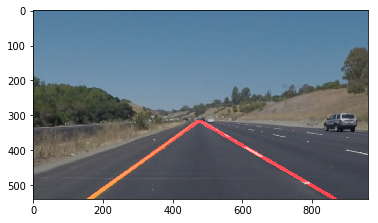

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import os

test_list=os.listdir("test_images/")
for test in test_list:
    img=mpimg.imread("test_images/"+test)
    reset_params_540p()
    processed_image=image_process(img)
    plt.imshow(processed_image, cmap='gray')
    #plt.savefig('annotated_images/'+test)
    plt.savefig('annotated_images/'+test)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
#pip install imageio
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Error while fetching file: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:719)>.
Error while fetching file: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:719)>.
Error while fetching file: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:719)>.
Error while fetching file: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:719)>.


OSError: Unable to download 'ffmpeg.linux64'. Perhaps there is a no internet connection? If there is, please report this problem.

In [3]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [4]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result=image_process(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
#reset_params_540p()
reset_params_720p()
white_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]


OSError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file test_videos_output/challenge.mp4:

 b"Unknown encoder 'libx264'\n"

The video export failed because FFMPEG didn't find the specified codec for video encoding (libx264). Please install this codec or change the codec when calling write_videofile. For instance:
  >>> clip.write_videofile('myvid.webm', codec='libvpx')

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

**"try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines"**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [23]:
#yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
#yellow_clip = clip2.fl_image(process_image)
#%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [24]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

OSError: [WinError 6] 핸들이 잘못되었습니다

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))